In [17]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from autograd.nn import MLP
import matplotlib.pyplot as plt
from autograd.engine import Value

from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix
from autograd.build_graph import draw_graph
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
! pip install ipywidgets --upgrade 
! jupyter nbextension enable --py widgetsnbextension 

In [6]:
X, y = make_moons(n_samples=500, noise=0.1, shuffle=True, random_state=42)
X.shape , y.shape , type(X) , type(y)

((500, 2), (500,), numpy.ndarray, numpy.ndarray)

In [8]:
moons = pd.DataFrame(data={"X1":X[:,0],
                           "X2":X[:,1],
                           "Label": y})
moons.sample(5)

,X1,X2,Label
276,1.246474,-0.494504,1
196,-0.211231,0.968159,0
461,0.622258,0.619988,0
53,1.385880,-0.379639,1
252,2.002653,0.177951,1


In [9]:
moons.Label.value_counts()

Label
1    250
0    250
Name: count, dtype: int64

In [10]:
moons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      500 non-null    float64
 1   X2      500 non-null    float64
 2   Label   500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [11]:
moons.describe(include='number')

,X1,X2,Label
count,500.000000,500.000000,500.000000
mean,0.509073,0.252683,0.500000
std,0.875322,0.508574,0.500501
min,-1.211402,-0.730705,0.000000
25%,-0.058213,-0.196850,0.000000
50%,0.480697,0.266967,0.500000
75%,1.074322,0.699982,1.000000
max,2.170605,1.242609,1.000000


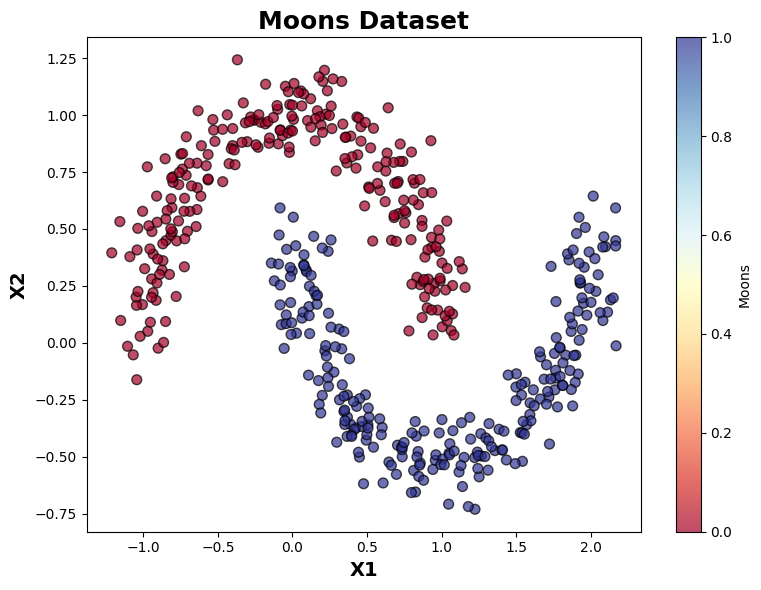

In [12]:
plt.figure(figsize = (8,6) ,dpi = 100)

# Scatter plot with enhancements
graph =  plt.scatter( x= moons['X1'],
                      y= moons['X2'],
                      c= moons['Label'],
                      cmap= plt.cm.RdYlBu,
                      alpha= 0.7,
                      edgecolors='k',
                      s = 50)

# Add colorbar to show the mapping of values to colors
plt.colorbar(graph , label = 'Moons')

# Add labels and title for better understanding
plt.xlabel('X1' ,fontsize = 14 ,fontweight = 'bold')
plt.ylabel('X2' ,fontsize = 14 ,fontweight = 'bold')
plt.title('Moons Dataset' ,fontsize = 18 ,fontweight = 'bold')

# Display the plot
plt.tight_layout()
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
len(X_train) ,len(X_test) ,len(y_train) ,len(y_test)

(350, 150, 350, 150)

In [14]:
model = MLP(nin=X.shape[1], nouts=[20,20,1], act_func='tanh')
model

In [15]:
model.summary()

Layer (type)         Output Shape         Param #   
Layer-1 ( 2 → 20)        [20]                60        
Layer-2 (20 → 20)        [20]                420       
Layer-3 (20 →  1)        [1]                 21        
Total params: 501


---
* The Hinge Loss is defined as:
$$
\text{loss} = \frac{1}{n} \sum_{i=1}^{n} \max(0,\, 1 - y_i f_i)
$$

In [16]:
def hinge_loss(model, logits, targets):
    # logits: list[Value]
    # targets: list or numpy array (0 or 1)

    # convert labels 0->-1, 1->+1
    y_signed = [1 if y > 0 else -1 for y in targets]

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(y_signed, logits)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(y_signed    , logits)]
    total_acc = sum(accuracy) / len(accuracy)
    return total_loss, total_acc

In [18]:
random.seed(42)
np.random.seed(42)

test_batch = 150
train_batch = 350

epoch = 200
epochs = []
test_losses = []
train_losses = []

for epoch in tqdm(range(epoch), desc="Training Epochs"):
  model.train()
  # Slpit data into batches
  ri = np.random.permutation(X_train.shape[0])[:train_batch]
  Xb, yb = X_train[ri] , y_train[ri]

  # forward Pass
  logits = list(map(model,Xb))

  # Calc Loss
  train_loss, train_acc = hinge_loss(model, logits, yb)

  # Optimizer zero_grad
  model.zero_grad()

  # Backpropagation
  train_loss.backward()

  # Optimizer step
  model.update(train_loss)

  if (epoch)%10==0:
    model.eval()
    #Split data into batches (no shuffle for test set)
    ri_test = np.arange(X_test.shape[0])[:test_batch]
    Xb_test, yb_test = X_test[ri_test] , y_test[ri_test]

    # forward pass
    test_logits = list(map(model,Xb_test))

    # Test loss
    test_loss, test_acc = hinge_loss(model, test_logits, yb_test)
    epochs.append(epoch)
    test_losses.append(test_loss.data)
    train_losses.append(train_loss.data)
    print(f"Epoch[{epoch}]: Train_Loss: {train_loss.data:.4f} | Train_acc: {train_acc * 100:.2f}% | Test_Loss: {test_loss.data:.4f} | Test_acc: {test_acc * 100:.2f}% | LR: {model.lr:.4f}")

Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch[0]: Train_Loss: 1.8232 | Train_acc: 23.14% | Test_Loss: 0.9161 | Test_acc: 50.67% | LR: 0.1020
Epoch[10]: Train_Loss: 0.2148 | Train_acc: 92.29% | Test_Loss: 0.1987 | Test_acc: 93.33% | LR: 0.1243
Epoch[20]: Train_Loss: 0.1547 | Train_acc: 96.86% | Test_Loss: 0.1603 | Test_acc: 94.00% | LR: 0.1486
Epoch[30]: Train_Loss: 0.1167 | Train_acc: 97.71% | Test_Loss: 0.1091 | Test_acc: 98.00% | LR: 0.1339
Epoch[40]: Train_Loss: 0.0978 | Train_acc: 98.00% | Test_Loss: 0.0901 | Test_acc: 98.67% | LR: 0.1182
Epoch[50]: Train_Loss: 0.0752 | Train_acc: 99.43% | Test_Loss: 0.0821 | Test_acc: 99.33% | LR: 0.1441
Epoch[60]: Train_Loss: 0.0705 | Train_acc: 100.00% | Test_Loss: 0.0757 | Test_acc: 99.33% | LR: 0.1224
Epoch[70]: Train_Loss: 0.0564 | Train_acc: 100.00% | Test_Loss: 0.0627 | Test_acc: 100.00% | LR: 0.1125
Epoch[80]: Train_Loss: 0.0511 | Train_acc: 100.00% | Test_Loss: 0.0559 | Test_acc: 100.00% | LR: 0.1292
Epoch[90]: Train_Loss: 0.0470 | Train_acc: 100.00% | Test_Loss: 0.0522 | Test_

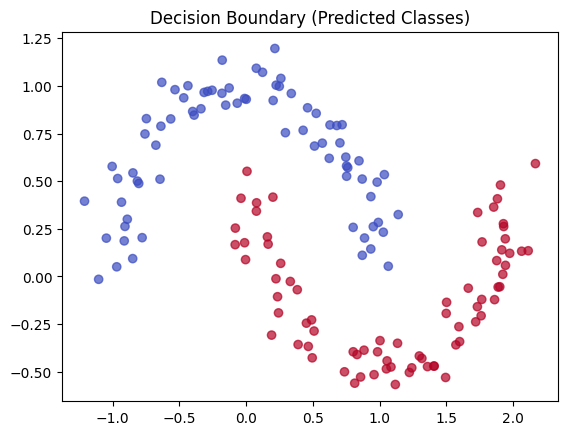

In [19]:
model.eval()
outputs = list(map(model, X_test))
preds = np.array([1 if v.data >= 0 else 0 for v in outputs])

plt.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='coolwarm', alpha=0.7)
plt.title("Decision Boundary (Predicted Classes)")
plt.show()

In [16]:
def plot_decision_boundary(Model ,X ,y):

  # Define grid for predictions
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features
  grid_points = np.c_[xx.ravel(), yy.ravel()]

  Model.eval()
  y_preds_list = []

  # --- Batch prediction to save memory ---
  batch_size = 512  # adjust for memory/speed
  for i in range(0, len(grid_points), batch_size):
    batch = grid_points[i:i + batch_size]

    # Convert batch to list of Value objects
    inputs = [[Value(val) for val in row] for row in batch]
    batch_logits = list(map(Model, inputs))

    # --- Handle output types ---
    if len(np.unique(y)) > 2:
      # multi-class: need to adapt if your model returns vector outputs
      logits_data = np.array([[v.data for v in out] for out in batch_logits])
      exp_logits = np.exp(logits_data - np.max(logits_data, axis=1, keepdims=True))
      softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
      y_preds_list.extend(np.argmax(softmax_probs, axis=1))

    else:
      # binary classification: just threshold logits
      y_preds_list.extend([1 if v.data > 0 else 0 for v in batch_logits])

  # Reshape preds and plot
  y_preds = np.array(y_preds_list).reshape(xx.shape)

  plt.contourf(xx, yy, y_preds, cmap=plt.cm.RdYlBu, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [17]:
def Display_Dcision_Boundary(Model, X_train, X_test, y_train, y_test):

  plt.figure(figsize=(10,5) ,dpi=100)
  plt.subplot(1,2,1)
  plt.title("Traning set" ,fontsize = 15 ,fontweight = 'bold')
  plot_decision_boundary(Model ,X_train ,y_train)
  # plt.axis('off')

  plt.subplot(1,2,2)
  plt.title("Testing set" ,fontsize = 15 ,fontweight = 'bold')
  plot_decision_boundary(Model ,X_test ,y_test)
  # plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def Display_train_test_loss_curves(epochs_count ,train_losses ,test_losses ,Model_name):
  plt.figure(figsize=(6,5) ,dpi=100)
  plt.plot(epochs_count ,train_losses ,c = 'b' ,label = "Train Loss")
  plt.plot(epochs_count ,test_losses ,c = 'r' ,label = "Test Loss")
  plt.ylabel("Loss" ,fontsize = 12 ,weight='bold')
  plt.xlabel("Epochs" ,fontsize = 12 ,weight='bold')
  plt.title(f"Traning and Testing Loss Curves/{Model_name}" ,fontsize = 12 ,weight='bold')
  plt.legend(prop = {"size":14},loc = "upper right")
  
  plt.tight_layout()
  plt.show()

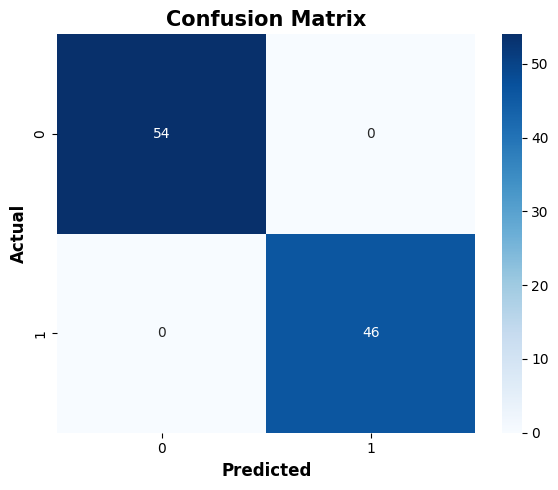


Conf_Matrix Output: 
[[54  0]
 [ 0 46]]

TN: 54 |FP: 0 |FN: 0 |TP: 46


In [23]:
# Generate confusion matrix
Conf_Matrix = confusion_matrix(y_test , preds)

# PLOT HEATMAP
plt.figure(figsize = (6,5) ,dpi=100)
sns.heatmap(Conf_Matrix ,cmap = plt.cm.Blues ,annot=True ,fmt ='d')
plt.title('Confusion Matrix',fontsize = 15 ,fontweight = 'bold')
plt.xlabel('Predicted' ,fontsize = 12 ,fontweight = 'bold')
plt.ylabel('Actual' ,fontsize = 12 ,fontweight = 'bold')
plt.tight_layout()
plt.show()

# Find TP ,TN ,FP ,FN
tn ,fp ,fn ,tp = Conf_Matrix.ravel()  # tabel order in sklearn

print(f"\nConf_Matrix Output: \n{Conf_Matrix}")
print(f"\nTN: {tn} |FP: {fp} |FN: {fn} |TP: {tp}")

In [ ]:
Display_train_test_loss_curves(epochs, train_losses, test_losses, Model_name="Moons_Model")

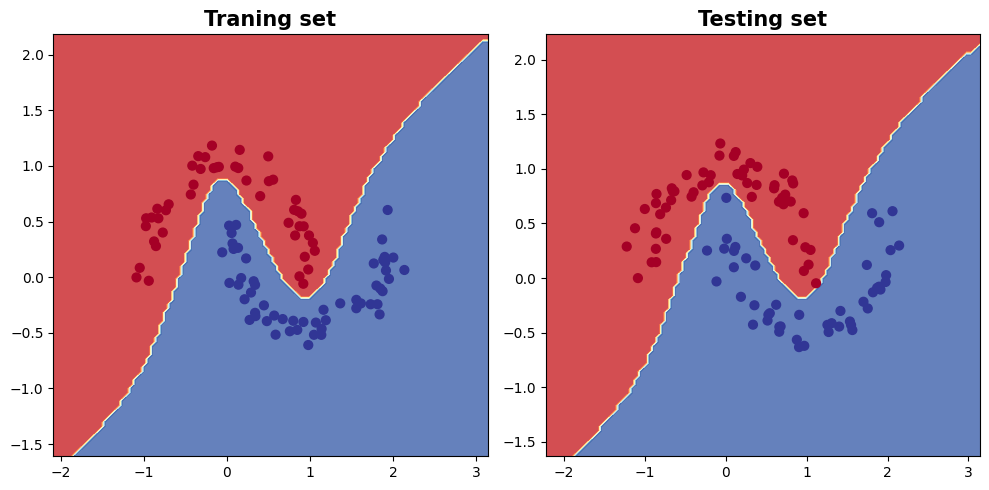

In [19]:
Display_Dcision_Boundary(model, X_train, X_test, y_train, y_test)